In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as back
from fitter import Fitter, get_common_distributions, get_distributions

2024-04-29 20:09:13.188798: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 20:09:13.189286: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 20:09:13.191871: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 20:09:13.221178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 20:09:13.877244: W tensorflow/compiler/tf2tensorrt/utils/py_uti

First, the cleaned data is read in from the csv. There are 15 subjects, who each performed 10 laps through 32 gates. X-Y gaze position was measured at every frame. Relative angular position between drone heading vector and gate normal vector were also calculated (I will refer to this as heading for ease). We want to identify the relationship between gaze position and heading.

In [39]:
ang = pd.read_csv('data/full_data2.csv', usecols=['Ang_Pos'], sep=';')
gaze = pd.read_csv('data/full_data2.csv', usecols=['Gaze.x.', 'Gaze.y.'], sep=';')

ang = ang.dropna()
gaze = gaze.dropna()

Then, the data is randomly split into train/test portions.

In [40]:
ang_train, ang_test, gaze_train, gaze_test = train_test_split(ang, gaze, test_size=0.33)

ang_train = ang_train.astype(np.float32)
ang_test = ang_test.astype(np.float32)

gaze_train = gaze_train.astype(np.float32)
gaze_test = gaze_test.astype(np.float32)

In [41]:
ang_train.shape, gaze_train.shape

((130487, 1), (130487, 2))

RELU was the best activation for the structure of our data, and the structure of the model was determined via tweaking to overcome the plateau at ~5.5 RMSE. 

Adam is a widely useful optimizer and mean_squared_error is the most appropriate regression loss function. The learning rate was reduced to minimize chances of plateauing at a local minimum.

In [91]:
gh_model = keras.Sequential([
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.1),
    
    keras.layers.Dense(1, activation='relu')
])

# Compile 
gh_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])

h = gh_model.fit(gaze_train, ang_train, batch_size=64, epochs=50, validation_split=0.1)

Epoch 1/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step - loss: 559.3212 - root_mean_squared_error: 20.1772 - val_loss: 28.1686 - val_root_mean_squared_error: 5.3078
Epoch 2/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - loss: 31.3643 - root_mean_squared_error: 5.5998 - val_loss: 28.1686 - val_root_mean_squared_error: 5.3078
Epoch 3/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - loss: 29.7616 - root_mean_squared_error: 5.4538 - val_loss: 28.1686 - val_root_mean_squared_error: 5.3078
Epoch 4/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - loss: 29.2466 - root_mean_squared_error: 5.4078 - val_loss: 28.1686 - val_root_mean_squared_error: 5.3078
Epoch 5/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - loss: 23.9347 - root_mean_squared_error: 4.8792 - val_loss: 12.2553 - val_root_mean_squared_error: 3.5011
Epoch 6/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 14.3507 - root_mean_squared_error: 3.7879 - val_loss: 11.8402 - val_root_mean_squared_error: 3.4413
Epoch 7/50
183

1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - loss: 12.3442 - root_mean_squared_error: 3.5128 - val_loss: 11.4531 - val_root_mean_squared_error: 3.3846
Epoch 43/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - loss: 12.8716 - root_mean_squared_error: 3.5872 - val_loss: 11.4507 - val_root_mean_squared_error: 3.3842
Epoch 44/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - loss: 12.8781 - root_mean_squared_error: 3.5878 - val_loss: 11.4384 - val_root_mean_squared_error: 3.3824
Epoch 45/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 12.7264 - root_mean_squared_error: 3.5670 - val_loss: 11.4561 - val_root_mean_squared_error: 3.3850
Epoch 46/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 13.0150 - root_mean_squared_error: 3.6067 - val_loss: 11.4330 - val_root_mean_squared_error: 3.3816
Epoch 47/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - loss: 13.0466 - root_mean_squared_error: 3.6113 - val_loss: 11.4824 - val_root_mean_squared_error: 3.3889
Epoch 48/50
1835/1835 

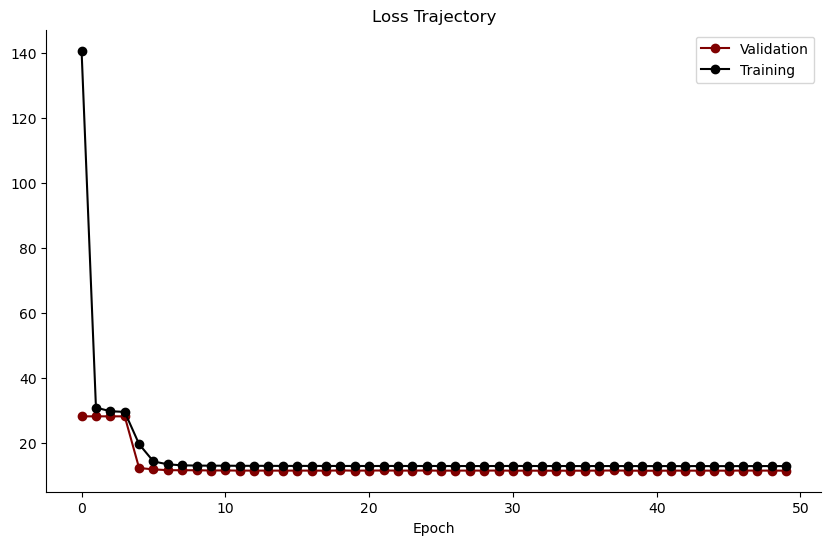

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(50), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(50), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
#ax.set_ylim(0, 50)
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

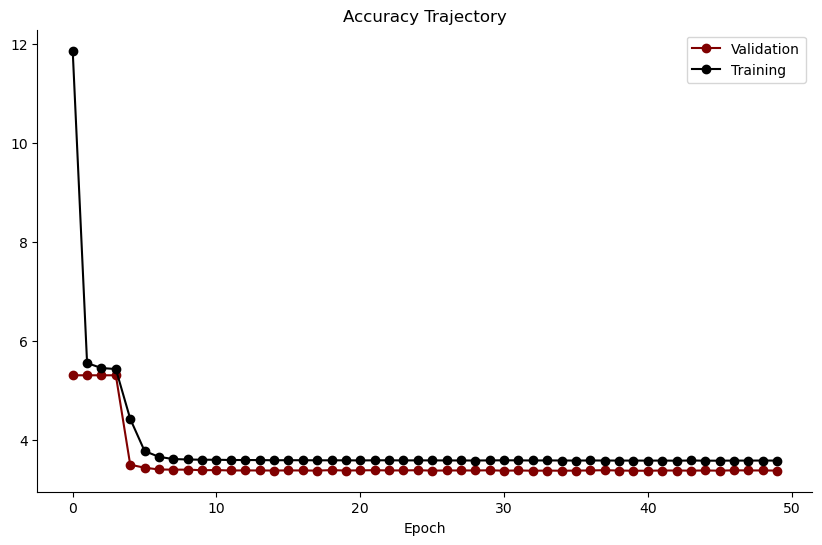

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(50), h.history['val_root_mean_squared_error'], 'o-', color='maroon', label='Validation')
ax.plot(range(50), h.history['root_mean_squared_error'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
#ax.set_ylim(0, 10)
ax.legend()
ax.set_title('Accuracy Trajectory')
sns.despine(ax=ax)

In [94]:
test_loss, test_accuracy = model.evaluate(gaze_test, ang_test)

2009/2009 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 28.8817 - root_mean_squared_error: 5.3736


In the interest of using this data to inform our likelihood, sample predictions were used to generate a distribution of possible "headings" (relative angular positions).

In [95]:
pred = gh_model.predict(gaze_test)

2009/2009 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


In [107]:
pred.min(), pred.max()

(3.6184723, 8.867556)

In [109]:
ang_test.Ang_Pos.min(), ang_test.Ang_Pos.max()

(-2.3804728984832764, 76.38558959960938)

The data is plotted to get an idea of the rel-ang-position relative frequencies.

(0.0, 15.0)

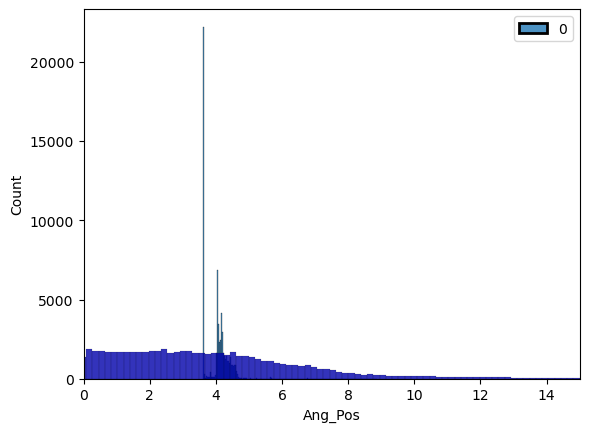

In [121]:
#sns.displot(data=pred, kind="hist", bins = 100, aspect = 1.5)
#plt.xlim(left=0, right=5)

sns.histplot(
    pred, color='#AA0000', alpha=0.8, lw=2, label=f'Predicted')
sns.histplot(
    ang_test.Ang_Pos, color='#0000AA', alpha=0.8, lw=2, label=f'Actual')
plt.xlim(left=0, right=15)

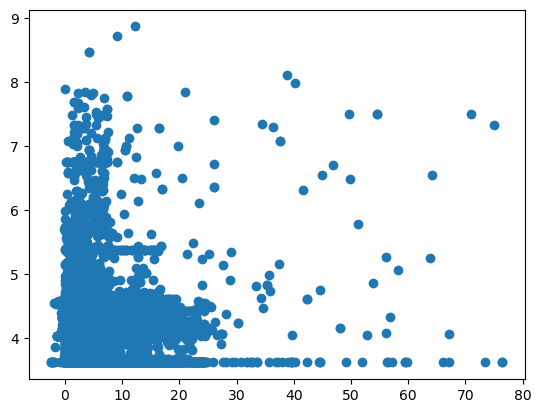

In [112]:
plt.scatter(ang_test, pred)

We also attempted to train a model to predict heading based on gaze, but this was not effective.

In [114]:
hg_model = keras.Sequential([
    keras.layers.Dense(8, activation='relu'),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation='relu'),
    #keras.layers.Dropout(0.1),
    
    keras.layers.Dense(2, activation='relu')
])

# Compile 
hg_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])

g = hg_model.fit(ang_train, gaze_train, batch_size=64, epochs=100, validation_split=0.1)


Epoch 1/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - loss: 651123.5000 - root_mean_squared_error: 792.6710 - val_loss: 79931.0781 - val_root_mean_squared_error: 282.7344
Epoch 2/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step - loss: 81712.2891 - root_mean_squared_error: 285.8421 - val_loss: 78852.1250 - val_root_mean_squared_error: 280.8168
Epoch 3/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 81173.2422 - root_mean_squared_error: 284.9066 - val_loss: 78803.2031 - val_root_mean_squared_error: 280.7292
Epoch 4/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - loss: 81095.8594 - root_mean_squared_error: 284.7719 - val_loss: 78795.9922 - val_root_mean_squared_error: 280.7160
Epoch 5/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - loss: 81055.3828 - root_mean_squared_error: 284.6994 - val_loss: 78702.6094 - val_root_mean_squared_error: 280.5503
Epoch 6/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - loss: 81424.2734 - root_mean_squared_error: 285.3378 - val_loss: 

1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - loss: 81190.8516 - root_mean_squared_error: 284.9350 - val_loss: 78611.8047 - val_root_mean_squared_error: 280.3881
Epoch 41/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 81043.2891 - root_mean_squared_error: 284.6750 - val_loss: 78738.2734 - val_root_mean_squared_error: 280.6150
Epoch 42/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 80617.3516 - root_mean_squared_error: 283.9278 - val_loss: 78603.3125 - val_root_mean_squared_error: 280.3735
Epoch 43/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 81116.6328 - root_mean_squared_error: 284.8069 - val_loss: 78707.9688 - val_root_mean_squared_error: 280.5598
Epoch 44/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 81803.2422 - root_mean_squared_error: 286.0042 - val_loss: 78663.4531 - val_root_mean_squared_error: 280.4818
Epoch 45/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step - loss: 81268.2500 - root_mean_squared_error: 285.0723 - val_loss: 78777.14

1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - loss: 81097.6797 - root_mean_squared_error: 284.7705 - val_loss: 78695.6875 - val_root_mean_squared_error: 280.5370
Epoch 80/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 81083.4141 - root_mean_squared_error: 284.7492 - val_loss: 78577.3281 - val_root_mean_squared_error: 280.3271
Epoch 81/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 80955.9219 - root_mean_squared_error: 284.5233 - val_loss: 78599.1172 - val_root_mean_squared_error: 280.3654
Epoch 82/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 81459.7812 - root_mean_squared_error: 285.4070 - val_loss: 78551.7578 - val_root_mean_squared_error: 280.2819
Epoch 83/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 80666.4297 - root_mean_squared_error: 284.0149 - val_loss: 78573.9922 - val_root_mean_squared_error: 280.3208
Epoch 84/100
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - loss: 80681.0078 - root_mean_squared_error: 284.0390 - val_loss: 78550.25

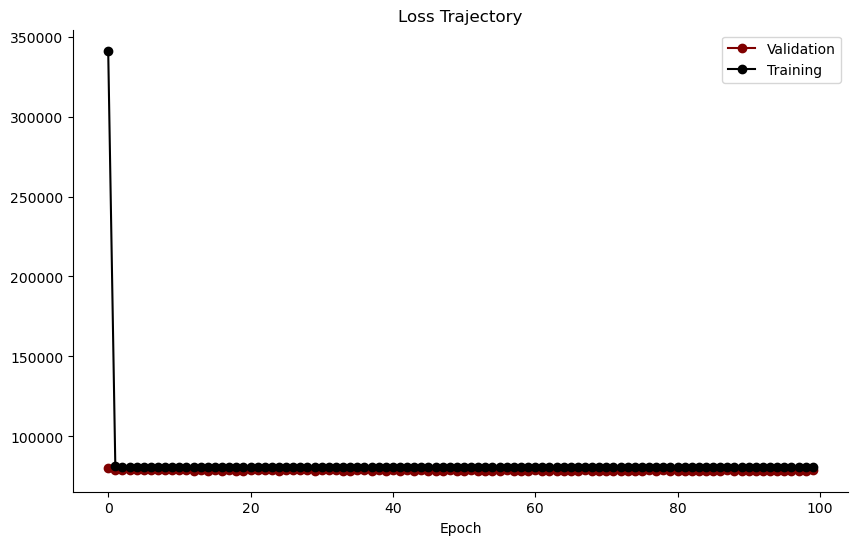

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(100), g.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(100), g.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
#ax.set_ylabel('Percentage error')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

In [136]:
test_loss, test_accuracy = hg_model.evaluate(ang_test, gaze_test)

2240/2240 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step - loss: 82.0181 - mean_absolute_percentage_error: 82.0181


In [137]:
test_loss, test_accuracy

(75.42182922363281, 75.44270324707031)